In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import csv
import pandas as pd
import json
import time
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string 
import unicodedata as ud
from greek_stemmer import GreekStemmer
import pymongo
import numpy as np
import re
import networkx as nx
import indexer as ind

### Find candidate domain-specific stopwords

In [9]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]

In [5]:
numdocs = list(index.find({ }, { "_id": 0, "list.numdoc": 1 }))
x = [numdocs[i]['list']['numdoc'] for i in range(len(numdocs))]
numdocs = {}
for numdoc in set(x):
    numdocs[numdoc] = x.count(numdoc)

In [6]:
print(f'Υπαρχουν {numdocs[1267]} documents με numdoc==1267')

Υπαρχουν 1 documents με numdoc==1267


(array([3052.,  794.,  315.,  180.,  110.,   86.,   63.,   43.,   38.,
          22.,   20.,   14.,   14.,   12.,   11.,    8.,    7.,    4.,
           8.,    5.,    4.,    5.,    5.]),
 array([     0.,   5000.,  10000.,  15000.,  20000.,  25000.,  30000.,
         35000.,  40000.,  45000.,  50000.,  55000.,  60000.,  65000.,
         70000.,  75000.,  80000.,  85000.,  90000.,  95000., 100000.,
        105000., 110000., 115000.]),
 <BarContainer object of 23 artists>)

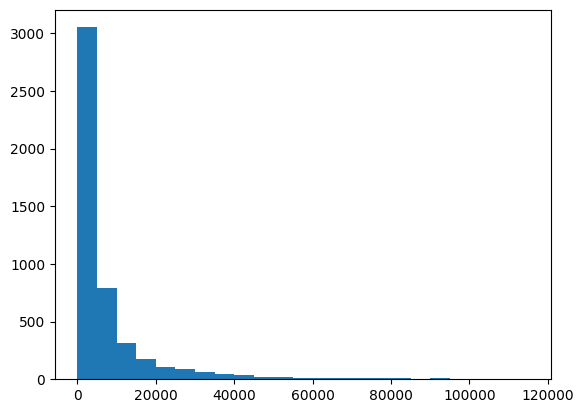

In [15]:
import matplotlib.pyplot as plt
n_bins = 20

# Generate two normal distributions

fig, axs = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
axs.hist(numdocs, bins=[i for i in range(0,120000,5000)])

In [19]:
threshold = list(index.find({"list.numdoc":{"$gt":60000}}, { "_id": 1, "list.numdoc": 1 }))
print([threshold[i]['_id'] for i in range(len(threshold))])

['ελλαδ', 'βουλ', 'συναδελφ', 'βουλευτ', 'δως', 'δημοκρατ', 'νομ', 'θεμ', 'διαταξ', 'προεδρ', 'υπαρχ', 'χωρ', 'γιν', 'υπουργ', 'νε', 'συμφων', 'αρθρ', 'επειδη', 'συνολ', 'δυο', 'τροπ', 'καλ', 'διαδικας', 'π', 'σχετ', 'εργ', 'ηθελ', 'ευχαριστ', 'συστημ', 'λειτουργ', 'προσωπ', 'ξερ', 'μεγαλ', 'κομμ', 'πολιτ', 'λα', 'ιδι', 'πραγματ', 'κρατ', 'μπορ', 'πολλ', 'δυνατοτητ', 'δημιουργ', 'συγκεκριμεν', 'δ', 'θες', 'κυβερνης', 'ελλην', 'πρωτ', 'προτας', 'στοιχει', 'περιπτως', 'βρισκ', 'συζητης', 'κυρι', 'δευτ', 'τελευται', 'βεβαιως', 'αποφας', 'ειδικ', 'κοινων', 'παρ', 'λογ', 'πραγμ', 'επιτροπ', 'ζητ', 'τελ', 'αρχ', 'πω', 'νομιζ', 'καν', 'γνωριζ', 'λε', 'μερ', 'στιγμ', 'υπηρες', 'θελ', 'αφορ', 'προβλημ', 'αναγκ', 'οικονομ', 'συζητ', 'εθν', 'αναπτυξ', 'σημαντικ', 'αναφερ', 'μιλ', 'φορ', 'γενικ', 'χρον', 'σχες', 'δημος', 'ευρ', 'πιστευ', 'ζητημ', 'μετρ', 'διν', 'εδω', 'ειπ', 'εγιν', 'δικ', 'τρ', 'νομοσχεδ', 'ερχ', 'υπουργει', 'γι’']


### Single Document Keyword Extraction with python libraries

In [19]:
document = list(database.find({"_id":"1"}, { "_id": 0, "speech": 1 }))
doc = document[0]['speech']
words_in_row = ind.preprocess_doc(document[0]['speech'], stopwords)

In [20]:
import yake
with open('stopwords.txt', encoding='utf-8') as file:
  stopwords = [line.rstrip() for line in file]
kw_extractor = yake.KeywordExtractor(top=10, stopwords=stopwords)
keywords = kw_extractor.extract_keywords(doc)
for kw, v in keywords:
  print("Keyphrase: ",kw, ": score", v)

Keyphrase:  Ιερά Σύνοδο εκτός : score 0.0006625251864205413
Keyphrase:  Αιθούσης της Βουλής : score 0.003765192744693946
Keyphrase:  Ιερά Σύνοδο : score 0.004515231779798047
Keyphrase:  Γραμματέας να συνοδεύσει : score 0.009753592200839796
Keyphrase:  συνοδεύσει την Ιερά : score 0.009753592200839796
Keyphrase:  Σύνοδο εκτός : score 0.009753592200839796
Keyphrase:  εκτός της Αιθούσης : score 0.009753592200839796
Keyphrase:  Βουλής : score 0.05594912775518909
Keyphrase:  Γραμματέας : score 0.06704428462937428
Keyphrase:  Ιερά : score 0.06704428462937428


In [22]:
print(get_keywords(database, "0"))

{'ιερ': 0.08571428571428572, 'σεραφειμ': 0.0857142857142857, 'συνοδευοντ': 0.07884353741496601, 'μελ': 0.078843537414966, 'ελλαδ': 0.07282312925170069, 'συνοδ': 0.07282312925170069, 'αθην': 0.07142857142857144, 'αιθους': 0.07142857142857144, 'πας': 0.06879251700680272, 'εισοδ': 0.06879251700680272, 'αρχιεπισκοπ': 0.05013605442176871, 'βουλ': 0.0501360544217687, 'αγιασμ': 0.049999999999999996, 'μακαρι': 0.04302721088435374, 'τελεσθ': 0.04302721088435374, 'συνοδευς': 0.04285714285714286, 'βουλγαρακ': 0.009591836734693878, 'συνεχει': 0.009591836734693878, 'γραμματ': 0.0017857142857142859, 'τελειτα': 0.0017857142857142859, 'παρακαλειτα': 0.0, 'καθιερωμεν': 0.0}
['ιερ', 'σεραφειμ', 'συνοδευοντ', 'μελ', 'ελλαδ']


### Single Document Keyword Extraction with Networkx

In [3]:
def create_graph_of_words(words_in_row:list)->nx.DiGraph:
    g = nx.DiGraph()
    #add unique words as nodes of the graph
    #g.add_nodes_from(set(words_in_row))
    for j,word in enumerate(words_in_row):
        #add word as a node if it doesnt exist
        if word not in g.nodes:
            g.add_node(word)    
        #generate list of indexes
        gen = (x for x in range(j+1,j+4) if x<len(words_in_row))
        for k in gen:
            #avoid self-loops
            if(word == words_in_row[k]):
                pass
            #if edge does not exist create it, else increase edge weight
            elif((word, words_in_row[k]) not in g.edges):
                g.add_edge(word, words_in_row[k])
                g[word][words_in_row[k]]['weight'] = 1
            else:
                g[word][words_in_row[k]]['weight'] += 1
    return g
def generate_graphs(total_documents:int, chunksize:int, database_collection):
    chunk = []
    counter = 0
    ticks = [x for x in range(0,total_documents,chunksize)]
    ticks.append(total_documents)
    graphs=[]
    with open('stopwords.txt', encoding='utf-8') as file:
        stopwords = [line.rstrip() for line in file]
    for j in range(len(ticks)-1):
        tokens = {}
        #read documents from MongoDB in chunks
        chunk = list(database_collection.find({ }, { "_id": 1, "speech": 1 })[ticks[j]:ticks[j+1]])
        print("Length of chunk: ", len(chunk))
        size_distribution = []
        #chunk = ["This is a sentance","This is another one"]
        #for each speech
        for i, row in enumerate(chunk):
            words_in_row = ind.preprocess_doc(row["speech"], stopwords)
            graph = create_graph_of_words(words_in_row)
            graphs.append(graph)
            #extract keywords and insert to mongo
   
        
        print("CHUNK", counter, " FINISHED")
    
    return graphs

def weighted_undirected_k_core(graph:nx.Graph):
    k = 0
    core_numbers = dict([(node,0) for node in graph.nodes])
    degrees = dict(graph.degree(weight='weight'))
    while(len(graph.nodes)>0):
        min_node = get_min_node(degrees)
        #print(min_node)
        if(degrees[min_node]>k):
            core_numbers[min_node] = degrees[min_node]
            k = core_numbers[min_node]
        else:
            core_numbers[min_node] = k
        for neighbor in graph.neighbors(min_node):
            degrees[neighbor] = degrees[neighbor]  - graph.get_edge_data(neighbor, min_node)['weight']
        graph.remove_node(min_node)
        del degrees[min_node]
        
    return core_numbers

def get_min_node(degrees):
    #sort degrees in increasing orders
    degrees = sorted(degrees.items(), key=lambda d: d[1])
    return degrees[0][0]

#returns the keywords for a document
def get_keywords(database_collection, document_id:string)->list:
    with open('stopwords.txt', encoding='utf-8') as file:
        stopwords = [line.rstrip() for line in file]
    tokens = {}
    #read documents from MongoDB in chunks
    document = list(database_collection.find({"_id":document_id}, { "_id": 0, "speech": 1 }))
    size_distribution = []
    #chunk = ["This is a sentance","This is another one"]
    #for each speech
    words_in_row = ind.preprocess_doc(document[0]['speech'], stopwords)
    graph = create_graph_of_words(words_in_row)
    #extract keywords and insert to mongo
    #core_numbers = weighted_undirected_k_core(graph)
    centrality = nx.betweenness_centrality(graph)
    centrality = dict(sorted(centrality.items(), key=lambda item: -item[1]))
    #print(centrality)
    words = list(centrality.keys())
    keywords = words[:int(len(words_in_row)/4)]

    return keywords


In [50]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]

In [71]:
#get keywords for a single document
keywords = get_keywords(database, "234")
print(keywords)


{'πολιτ': 0.3572644608551125, 'κυβερνης': 0.1670047360514471, 'ειπ': 0.12939892316319912, 'πραγματ': 0.1104672301027447, 'συνασπισμ': 0.10569015486580276, 'νε': 0.09694859568419974, 'δημοκρατ': 0.09586480901636865, 'συγκυβερνης': 0.08738160619723236, 'πασοκ': 0.08246529959489976, 'κρατ': 0.06846865595423295, 'αποφας': 0.06726673326938995, 'μιλ': 0.06438328745227527, 'μινιμουμ': 0.05756231194120392, 'θεμ': 0.05656285993770532, 'παρ': 0.05173578290186787, 'κυβερν': 0.051023707198146466, 'επρεπ': 0.044266165660291734, 'χρον': 0.04302205549830263, 'πανω': 0.0409863777387555, 'ομοψυχ': 0.03803534002301355, 'γνωριζ': 0.03684056018339678, 'διευθυντ': 0.035545237831017935, 'μερ': 0.031476789488799194, 'ακυβερνης': 0.02875234951998579, 'τρεχ': 0.026568206372375475, 'θετ': 0.023719695704989826, 'εσωτερ': 0.023184711850695105, 'στιγμ': 0.022785349833857504, 'εμπιστοσυν': 0.022015630402358898, 'υπαρχ': 0.021533636366399225, 'αρχηγ': 0.018797862644233308, 'μητσοτακ': 0.01792481038767405, 'καταδειχθ

In [ ]:
#test, pls ignore
dataframe1 = list(database.find({ }, { "_id": 1, "speech": 1 })[:100000])
for i, row in enumerate(dataframe1):
    #print(row["_id"])
    pass

In [ ]:
#print(graphs[0].edges)
import matplotlib.pyplot as plt
 
plt.savefig('graph.png')
# larger figure size
#pos = nx.circular_layout(graphs[2])

plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(graphs[0], with_labels=True,node_size=80,font_size=15)
plt.show()

### Extract keywords for a parliament member

In [18]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]

In [5]:
#get distinct parliament member names in a list
member_names = database.distinct("member_name")

In [20]:
def get_member_keywords(member_name:string)->list:
    #get ids of member's total speeches
    member_speeches = list(database.find({"member_name": member_name}, { "_id": 1, "speech": 0 }))
    total_keywords = []
    for speech in member_speeches:
        keywords = get_keywords(database, speech['_id'])
        total_keywords.extend(keywords)
    keyword_frequency = {}
    for keyword in set(total_keywords):
        keyword_frequency[keyword] = total_keywords.count(keyword)
    keyword_frequency = sorted(keyword_frequency.items(), key=lambda d: d[1], reverse=True)
    return keyword_frequency[:10]

In [21]:
print(get_member_keywords(member_name=member_names[10]))

## Networkx library test

In [ ]:
#networkx library
import networkx as nx
g = nx.Graph()
l = ['1','2','3']
#g.add_nodes_from(l)

for word in l:
    if(word not in list(g.nodes)):
        g.add_node(word)
for e in list(g.nodes):
    print(e)
    
g.add_edge('1','2')
g.add_edge('2','3')
if(('1','2') in g.edges):
    print(' in')
for e in list(g.edges):
    print(e)

In [ ]:

graphs = generate_graphs(100,100,database)
graph = graphs[78]
for node in graph.nodes:
    for neighbor in graph.neighbors(node):
        if(graph.get_edge_data(neighbor, node)['weight']>1):
            print(graph.get_edge_data(neighbor, node)['weight'])

In [ ]:
core_numbers = dict(core_numbers)
max_core = [num for num in core_numbers.values() if(num==2)]
print(len(max_core))

In [ ]:
test = nx.Graph()
test.add_nodes_from([1,2,3,4,5,6])
test.add_edge(1,2)
test[1][2]['weight'] = 2
test.add_edge(1,4)
test[1][4]['weight'] = 4

test.add_edge(2,3)
test[2][3]['weight'] = 3

test.add_edge(3,4)
test[3][4]['weight'] = 5

test.add_edge(3,5)
test[3][5]['weight'] = 7

test.add_edge(4,5)
test[4][5]['weight'] = 6

test.add_edge(5,6)
test[5][6]['weight'] = 8



In [ ]:
k = 0
core_numbers = dict([(node,0) for node in test.nodes])
#print(graph.nodes)
print('sdfdsf.',len(nx.k_core(test).nodes))
degrees = dict(test.degree(weight='weight'))
while(len(test.nodes)>0):
    min_node = get_min_node(degrees)
    #print(min_node)
    if(degrees[min_node]>k):
        core_numbers[min_node] = degrees[min_node]
        k = core_numbers[min_node]
    else:
        core_numbers[min_node] = k
    for neighbor in test.neighbors(min_node):
        print(neighbor)
        degrees[neighbor] = degrees[neighbor]  - test.get_edge_data(min_node, neighbor)['weight']
    test.remove_node(min_node)
    del degrees[min_node]
    
print(sorted(core_numbers.items(), key=lambda d: d[1]))
print(len(core_numbers))